In [172]:
#Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

#sns.set_theme(style='whitegrid', palette='pastel')
sns.set_theme(style = "ticks", context = "talk", palette = "bright")
#sns.color_palette("Paired")

In [173]:
#Import des DataFrames
commune=pd.read_parquet('donnee-comm-data.gouv-parquet-2023-geographie2024-produit-le2024-07-05.parquet')
dep=pd.read_csv('donnee-dep-data.gouv-2023-geographie2024-produit-le2024-07-05.csv',sep=';')
reg=pd.read_csv('donnee-reg-data.gouv-2023-geographie2024-produit-le2024-07-05.csv',sep=';')
commune.tail(10)

,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG
3917750,97617,23,Vols avec armes,infraction,diff,42.0,3.014210,NaN,NaN,13934,17,3872.0,17
3917751,97617,23,Vols violents sans arme,infraction,diff,14.0,1.004737,NaN,NaN,13934,17,3872.0,17
3917752,97617,23,Vols sans violence contre des personnes,victime entendue,diff,53.0,3.803646,NaN,NaN,13934,17,3872.0,17
3917753,97617,23,Cambriolages de logement,infraction,diff,28.0,7.231405,NaN,NaN,13934,17,3872.0,17
3917754,97617,23,Vols de véhicules,véhicule,diff,26.0,1.865939,NaN,NaN,13934,17,3872.0,17
3917755,97617,23,Vols dans les véhicules,véhicule,diff,19.0,1.363571,NaN,NaN,13934,17,3872.0,17
3917756,97617,23,Vols d'accessoires sur véhicules,véhicule,ndiff,NaN,NaN,2.733333,0.234555,13934,17,3872.0,17
3917757,97617,23,Destructions et dégradations volontaires,infraction,diff,87.0,6.243720,NaN,NaN,13934,17,3872.0,17
3917758,97617,23,Trafic de stupéfiants,Mis en cause,ndiff,NaN,NaN,2.500000,0.216122,13934,17,3872.0,17
3917759,97617,23,Usage de stupéfiants,Mis en cause,ndiff,NaN,NaN,7.500000,0.673906,13934,17,3872.0,17


# I) Nettoyage des données dans les différents DataFrames
## A) Vérification de la cohérence et de l'uniformité des données
### 1) Vérification de la cohérence
Tout d'abord, il convient de vérifier que chaque variable est au bon type. L'objectif est d'avoir une uniformité des types de valeurs entre les 3 DataFrames commune, dep et reg. 
A noter que les dates seront traitées séparément car elles font l'objet d'une traitement particulier


In [174]:
## DataFrame commune
#les colonnes classe et unité.de.compte doivent être au format object
commune['classe']=commune['classe'].astype('str')
commune['unité.de.compte']=commune['unité.de.compte'].astype('str')
commune.info()
## DataFrame dep
dep.info()
## DataFrame reg
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3917760 entries, 0 to 3917759
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CODGEO_2024         object 
 1   annee               int32  
 2   classe              object 
 3   unité.de.compte     object 
 4   valeur.publiée      object 
 5   faits               float64
 6   tauxpourmille       float64
 7   complementinfoval   float64
 8   complementinfotaux  float64
 9   POP                 int32  
 10  millPOP             int32  
 11  LOG                 float64
 12  millLOG             int32  
dtypes: float64(5), int32(4), object(4)
memory usage: 328.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12928 entries, 0 to 12927
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   classe            12928 non-null  object
 1   annee             12928 non-null  int64 
 2   Code.département  12928 non-nu

### 2) Vérification de l'uniformité des données
Il convient de vérifier que les données sont uniformes, c'est à dire qu'elles doivent être écrites toujours de la même manière en respectant une règle unique
#### a) Données quantitatives

In [175]:
reg.head(1)

,classe,annee,Code.région,unité.de.compte,millPOP,millLOG,faits,POP,LOG,tauxpourmille
0,Homicides,16,1,victime,16,16,32,394110,"226105,0475677566","0,08119560528786381"


In [176]:
## DataFrame commune
commune['annee'].unique() #Toutes les années sont écrites au même format
commune['classe'].unique() #Toutes les classes sont écrites au même format et il n'y en a pas deux identiques écrites différemment 
commune['unité.de.compte'].unique() #Ici victime et victime entendue correspondent a la même unité de compte. Il faut donc modifier cela 
commune['unité.de.compte']=commune['unité.de.compte'].replace('victime entendue','victime')
commune['valeur.publiée'].unique() #Toutes les valeurs publiées sont écrites au même format 

## DataFrame dep
dep['annee'].unique() #Toutes les années sont écrites au même format
dep['classe'].unique() #Toutes les années sont écrites au même format
dep['Code.département'].unique() #Tous les départements sont écrits au même format sans erreur de doublon. A noter qu'il est normal que la valeur "20" soit manquante puisqu'il s'agit de la corse, dont le code a été remplacé en 1976 par 2A et 2B
dep['unité.de.compte'].unique() #Ici victime et victime entendue correspondent a la même unité de compte. Il faut donc modifier cela 
dep['unité.de.compte']=dep['unité.de.compte'].replace('victime entendue','victime')

## DataFrame reg
reg['annee'].unique() #Toutes les années sont écrites au même format
reg['classe'].unique() #Toutes les années sont écrites au même format
reg['Code.région'].unique() #Toutes les régions sont présentes et sont écrites au même format 

array([ 1,  2,  3,  4,  6, 11, 24, 27, 28, 32, 44, 52, 53, 75, 76, 84, 93,
       94])

#### b) Dates
L'étude des formats a démontré que les dates (ici "annee") sont au format int, ce qui est incorrect. Pour la suite de l'analyse, ces variables doivent être au format datetime64. 

In [177]:
commune['annee'] = pd.to_datetime(commune['annee'].apply(lambda x: f"20{x:02d}"))
dep['annee'] = pd.to_datetime(dep['annee'].apply(lambda x: f"20{x:02d}"))
reg['annee'] = pd.to_datetime(reg['annee'].apply(lambda x: f"20{x:02d}"))

## B) Vérifications des doublons

In [178]:
# Recherche de doublons 
print('Il y a',commune.duplicated().sum(),'doublons dans le df commune')
print('Il y a',dep.duplicated().sum(),'doublons dans le df dep')
print('Il y a',reg.duplicated().sum(),'doublons dans le df reg')

Il y a 0 doublons dans le df commune
Il y a 0 doublons dans le df dep
Il y a 0 doublons dans le df reg


## C) Vérification des valeurs manquantes
### 1) Analyse globale

In [179]:
# Recherche de valeurs manquantes du df departement 
print('Il y a',dep.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df departement')
# Recherche de valeurs manquantes sur les lignes du df département
#dep.isna().any(axis = 1).sum() Inutile donc 

Il y a 0 colonnes contenant des valeurs manquantes dans le df departement


In [180]:
# Recherche de valeurs manquantes du df région
print('Il y a',reg.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df reg')
# Recherche de valeurs manquantes sur les lignes du df régions
#reg.isna().any(axis = 1).sum() Inutile donc 

Il y a 0 colonnes contenant des valeurs manquantes dans le df reg


In [181]:
# Recherche de valeurs manquantes sur les colonnes du df commune
print('Il y a',commune.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df commune') 
# Recherche de valeurs manquantes sur les lignes du df communes
print('Il y a',commune.isna().any(axis = 1).sum(),'lignes contenant des valeurs manquantes sur',commune.shape[0],'lignes sur le df.')
print('Les colonnes concernées sont les colonnes faits, taux pour mille, complementinfoval, complementinfototaux')

Il y a 4 colonnes contenant des valeurs manquantes dans le df commune
Il y a 3917760 lignes contenant des valeurs manquantes sur 3917760 lignes sur le df.
Les colonnes concernées sont les colonnes faits, taux pour mille, complementinfoval, complementinfototaux


### 2) Traitement des valeurs manquantes
Le fichier des métadonnées du dataset indique que si la variable contenue dans la colonne "valeur.publiée" vaut ndiff, alors les variables contenues dans la colonne "faits" et "tauxpourmille" ne seront pas renseignées. De ce fait, il a été décidé de supprimer toutes les lignes donc la colonne "valeur.publiée" vaut ndiff. 

In [182]:
#Suppression des valeurs manquantes dans la colonne "faits"
commune.loc[commune['valeur.publiée'] == 'ndiff', 'faits'] = 0.0

#Suppression des valeurs manquantes dans la colonne "tauxpourmille"
commune.loc[commune['valeur.publiée'] == 'ndiff', 'tauxpourmille'] = 0.0
commune.isna().any(axis = 0)
#On  observe qu'il reste des NaN. On les localise et on étudie
commune.loc[commune[['tauxpourmille']].isna().any(axis=1)]
#Les NAN restants peuvent être recalculés car le taux pour mille est le nombre de faits divisé par millpop 
commune['millPOP'].unique() #On vérifie que millPOP ne prend pas la valeur 0 auquel cas la division serait impossible 
commune['tauxpourmille']=commune['tauxpourmille'].fillna(commune['faits']/commune['millPOP'])
commune.isna().any(axis = 0)
#Les colonnes "complementinfoval" et "complementinfototaux" contiennent encore des NaN mais ne sont pas utiles pour l'étude. 
commune.tail()


,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG
3917755,97617,2023-01-01,Vols dans les véhicules,véhicule,diff,19.0,1.363571,NaN,NaN,13934,17,3872.0,17
3917756,97617,2023-01-01,Vols d'accessoires sur véhicules,véhicule,ndiff,0.0,0.000000,2.733333,0.234555,13934,17,3872.0,17
3917757,97617,2023-01-01,Destructions et dégradations volontaires,infraction,diff,87.0,6.243720,NaN,NaN,13934,17,3872.0,17
3917758,97617,2023-01-01,Trafic de stupéfiants,Mis en cause,ndiff,0.0,0.000000,2.500000,0.216122,13934,17,3872.0,17
3917759,97617,2023-01-01,Usage de stupéfiants,Mis en cause,ndiff,0.0,0.000000,7.500000,0.673906,13934,17,3872.0,17


Certaines colonnes ne sont pas utiles pour cette étude. Il convient donc de les supprimer. 
Si dans le futur il s'avère qu'il est nécessaire de les garder, il suffira de supprimer la cellule suivante. L'argument inplace est donc laissé a sa valeur par défaut (false)

In [183]:
## DataFrame commune
commune=commune.drop("complementinfoval", axis=1)
commune=commune.drop("complementinfotaux", axis=1)
commune=commune.drop("LOG", axis=1)
commune=commune.drop("millLOG", axis=1)
## DataFrame reg
reg=reg.drop("LOG", axis=1)
reg=reg.drop("millLOG", axis=1)
## DataFrame dep
dep=dep.drop("LOG", axis=1)
dep=dep.drop("millLOG", axis=1)




## D) Autres préprocessings
Renommage des colonnes pour une meilleure lisibilité et faciliter les prochains devs 

In [184]:
## DataFrame commune
dictionnaire = {'CODGEO_2024': 'codgeo',
                'unité.de.compte': 'cible',
                'valeur.publiée': 'publication',
                'POP':'pop',
                'millPOP':'millpop'}
commune=commune.rename(dictionnaire, axis = 1) 
## DataFrame reg
dictionnaire = {'Code.région': 'region',
                'unité.de.compte': 'cible',
                'POP':'pop',
                'millPOP':'millpop'}
reg=reg.rename(dictionnaire, axis = 1)
## DataFrame dep
dictionnaire = {'Code.département': 'departement',
                'Code.région': 'region',
                'unité.de.compte': 'cible',
                'POP':'pop',
                'millPOP':'millpop'}
dep=dep.rename(dictionnaire, axis = 1)
#dep.head(1)

Les codes des départements et des régions ne sont que très peu parlants. Afin de faciliter le post-processing des études, il convient de remplacer les codes par leur nom complet. 

In [185]:
## DataFrame reg
#L'idée est ici de créer un dictionnaire clé-valeur issu d'un json (source dans le fichier README) pour "traduire" le code dans le nom de la région
json_cles_reg=pd.read_json('anciennes-nouvelles-regions.json')
dico_reg=json_cles_reg.set_index('new_code')['region'].to_dict()
reg['region']=reg['region'].map(dico_reg)
reg.tail(10)

,classe,annee,region,cible,millpop,faits,pop,tauxpourmille
2294,Usage de stupéfiants,2023-01-01,NORMANDIE,Mis en cause,21,12903,3327966,"3,87714297561934229"
2295,Usage de stupéfiants,2023-01-01,HAUTS DE FRANCE,Mis en cause,21,23724,5995292,"3,95710500839658863"
2296,Usage de stupéfiants,2023-01-01,GRAND EST,Mis en cause,21,14440,5561287,"2,59652127286363754"
2297,Usage de stupéfiants,2023-01-01,PAYS DE LA LOIRE,Mis en cause,21,8537,3853999,"2,21510176831908856"
2298,Usage de stupéfiants,2023-01-01,BRETAGNE,Mis en cause,21,8551,3394567,"2,51902525417822076"
2299,Usage de stupéfiants,2023-01-01,NOUVELLE AQUITAINE,Mis en cause,21,14637,6069352,"2,41162483243680725"
2300,Usage de stupéfiants,2023-01-01,OCCITANIE,Mis en cause,21,21171,6022176,"3,51550668728379900"
2301,Usage de stupéfiants,2023-01-01,AUVERGNE RHONE ALPES,Mis en cause,21,28978,8114361,"3,57119926017587819"
2302,Usage de stupéfiants,2023-01-01,PROVENCE ALPES COTE D AZUR,Mis en cause,21,37290,5127840,"7,27206777122531101"
2303,Usage de stupéfiants,2023-01-01,CORSE,Mis en cause,21,849,347597,"2,44248368081427625"


In [186]:
## DataFrame dep 
#On commence par modifier comme précédemment les codes des régions par leur nom 
dep['region']=dep['region'].map(dico_reg)
#Ensuite il va falloir créer un nouveau dictionnaire clé-valeur avec un fichier csv (source dans le fichier README)
csv_cles_dep=pd.read_csv('georef-france-departement.csv',sep = ';')
dico_dep=csv_cles_dep.set_index('Code Officiel Département')['Nom Officiel Département Majuscule'].to_dict()
dep['departement']=dep['departement'].map(dico_dep)
dep.head()

,classe,annee,departement,region,cible,millpop,faits,pop,tauxpourmille
0,Homicides,2016-01-01,AIN,AUVERGNE RHONE ALPES,victime,16,5,638425,"7,83177350511023e-03"
1,Homicides,2016-01-01,AISNE,HAUTS DE FRANCE,victime,16,10,536136,"1,86519838249996e-02"
2,Homicides,2016-01-01,ALLIER,AUVERGNE RHONE ALPES,victime,16,4,339384,"1,17860594488839e-02"
3,Homicides,2016-01-01,ALPES DE HAUTE PROVENCE,PROVENCE ALPES COTE D AZUR,victime,16,2,162565,"1,23027711992126e-02"
4,Homicides,2016-01-01,HAUTES ALPES,PROVENCE ALPES COTE D AZUR,victime,16,0,141107,"0,00000000000000e+00"


In [187]:
## DataFrame commune 
csv_cles_com=pd.read_csv('v_commune_2024.csv')
dico_com=csv_cles_com.set_index('COM')['NCC'].to_dict()
commune['codgeo']=commune['codgeo'].map(dico_com)

commune.head(1)

,codgeo,annee,classe,cible,publication,faits,tauxpourmille,pop,millpop
0,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16


In [188]:
#Il convient de vérifier que les étapes précédentes n'ont pas généré de NaN 
print('Il y a',dep.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df departements')
print('Il y a',reg.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df regions')
print('Il y a',commune.isna().any(axis = 0).sum(),'colonnes contenant des valeurs manquantes dans le df communes')

Il y a 0 colonnes contenant des valeurs manquantes dans le df departements
Il y a 0 colonnes contenant des valeurs manquantes dans le df regions
Il y a 0 colonnes contenant des valeurs manquantes dans le df communes


In [189]:
#On peut renommer la colonne "codgeo" qui n'est plus représentatif des variables qu'elle contient
dictionnaire = {'codgeo': 'ville',
                }
commune=commune.rename(dictionnaire, axis = 1)
commune.head(1)


,ville,annee,classe,cible,publication,faits,tauxpourmille,pop,millpop
0,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16


## E) Statistiques exploratoires
### 1) Recherche, analyse et traitement des outliers 

In [190]:
##DataFrame commune
commune.describe()
#On observe une très grand disparité dans le nombre de faits

,annee,faits,tauxpourmille,pop,millpop
count,3917760,3.917760e+06,3.917760e+06,3.917760e+06,3.917760e+06
mean,2019-07-02 18:00:00.000004352,5.899028e+00,4.265138e-01,2.024106e+03,1.912397e+01
min,2016-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01
25%,2017-10-01 18:00:00,0.000000e+00,0.000000e+00,1.980000e+02,1.700000e+01
50%,2019-07-02 12:00:00,0.000000e+00,0.000000e+00,4.580000e+02,1.900000e+01
75%,2021-04-02 06:00:00,0.000000e+00,0.000000e+00,1.166000e+03,2.100000e+01
max,2023-01-01 00:00:00,1.617450e+05,1.440000e+03,2.190327e+06,2.100000e+01
std,NaN,2.138605e+02,3.291948e+00,1.541030e+04,1.833013e+00


,ville,annee,classe,cible,publication,faits,tauxpourmille,pop,millpop
1878932,PARIS,2019-01-01,Vols sans violence contre des personnes,victime,diff,161745.0,74.694413,2165423,19
1389212,PARIS,2018-01-01,Vols sans violence contre des personnes,victime,diff,139272.0,64.015415,2175601,18
899492,PARIS,2017-01-01,Vols sans violence contre des personnes,victime,diff,132888.0,60.748078,2187526,17
409772,PARIS,2016-01-01,Vols sans violence contre des personnes,victime,diff,131092.0,59.850424,2190327,16
3348092,PARIS,2022-01-01,Vols sans violence contre des personnes,victime,diff,120883.0,56.669812,2133111,21
3837812,PARIS,2023-01-01,Vols sans violence contre des personnes,victime,diff,112610.0,52.791439,2133111,21
2368652,PARIS,2020-01-01,Vols sans violence contre des personnes,victime,diff,109981.0,51.251546,2145906,20
2858372,PARIS,2021-01-01,Vols sans violence contre des personnes,victime,diff,106834.0,50.083657,2133111,21
1878937,PARIS,2019-01-01,Destructions et dégradations volontaires,infraction,diff,28354.0,13.093977,2165423,19
1389217,PARIS,2018-01-01,Destructions et dégradations volontaires,infraction,diff,27527.0,12.652596,2175601,18


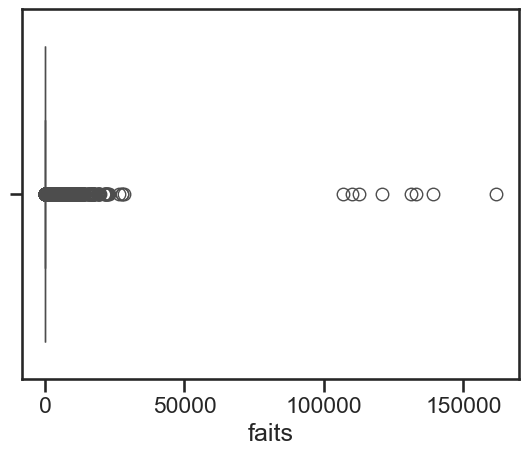

In [191]:
#On trace le diagramme en moustache qui affiche la répartition
sns.boxplot(x = 'faits', data = commune)
#On observe qu'il y a 8 outliers. Afin de procéder au traitement le plus adapté, il va falloir étudier si ce sont des valeurs extrêmes ou des valeurs aberrantes. 

#Pour cela, on trie le DataFrame par nombre de faits décroissants 
comm_sorted = commune.sort_values(by = 'faits', ascending = False)
comm_sorted.head(10) 

In [192]:
#On observe que le nombre de faits est dans un premier temps corrélé au taux pour mille. De plus, le rapport d'enquête de 2029 édité par le ministère de l'intérieur confirme ces chiffres. 
#Ces valeurs représentent donc des valeurs extrêmes et non des valeurs aberrantes. Elles sont donc gardées dans le dataset. 

In [193]:
#Etude de la distribution des cibles

In [194]:
##DataFrame dep
dep.describe()

,annee,millpop,faits,pop
count,12928,12928.000000,12928.000000,1.292800e+04
mean,2019-07-02 17:59:59.999999744,19.103960,1980.332225,6.658978e+05
min,2016-01-01 00:00:00,16.000000,0.000000,7.642200e+04
25%,2017-10-01 18:00:00,17.000000,264.000000,2.829485e+05
50%,2019-07-02 12:00:00,19.000000,825.000000,5.303595e+05
75%,2021-04-02 06:00:00,21.000000,2083.250000,8.414820e+05
max,2023-01-01 00:00:00,21.000000,161745.000000,2.611293e+06
std,NaN,1.835931,4497.277245,5.100051e+05


,classe,annee,departement,region,cible,millpop,faits,pop,tauxpourmille
6034,Vols sans violence contre des personnes,2019-01-01,PARIS,ILE DE FRANCE,victime,19,161745,2165423,"7,46944130546318e+01"
5933,Vols sans violence contre des personnes,2018-01-01,PARIS,ILE DE FRANCE,victime,18,139272,2175601,"6,40154145911865e+01"
5832,Vols sans violence contre des personnes,2017-01-01,PARIS,ILE DE FRANCE,victime,17,132888,2187526,"6,07480779657019e+01"
5731,Vols sans violence contre des personnes,2016-01-01,PARIS,ILE DE FRANCE,victime,16,131092,2190327,"5,98504241604108e+01"
6337,Vols sans violence contre des personnes,2022-01-01,PARIS,ILE DE FRANCE,victime,21,120883,2133111,"5,66698123070014e+01"
6438,Vols sans violence contre des personnes,2023-01-01,PARIS,ILE DE FRANCE,victime,21,112610,2133111,"5,27914393578206e+01"
6135,Vols sans violence contre des personnes,2020-01-01,PARIS,ILE DE FRANCE,victime,20,109981,2145906,"5,12515459670647e+01"
6236,Vols sans violence contre des personnes,2021-01-01,PARIS,ILE DE FRANCE,victime,21,106834,2133111,"5,00836571561442e+01"
6028,Vols sans violence contre des personnes,2019-01-01,RHONE,AUVERGNE RHONE ALPES,victime,19,33572,1875747,"1,78979361289129e+01"
6230,Vols sans violence contre des personnes,2021-01-01,RHONE,AUVERGNE RHONE ALPES,victime,21,33489,1893692,"1,76845020203919e+01"


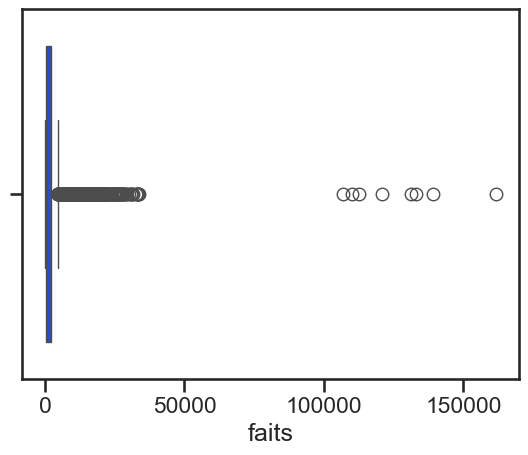

In [195]:
#Tracé de la distribution de la variable faits
sns.boxplot(x = 'faits', data = dep)
#Sans surprise, il y a également des valeurs extrêmes en région parisienne. 
dep_sorted = dep.sort_values(by = 'faits', ascending = False)
dep_sorted.head(10) 

In [196]:
##DataFrame reg 
dep.describe()

,annee,millpop,faits,pop
count,12928,12928.000000,12928.000000,1.292800e+04
mean,2019-07-02 17:59:59.999999744,19.103960,1980.332225,6.658978e+05
min,2016-01-01 00:00:00,16.000000,0.000000,7.642200e+04
25%,2017-10-01 18:00:00,17.000000,264.000000,2.829485e+05
50%,2019-07-02 12:00:00,19.000000,825.000000,5.303595e+05
75%,2021-04-02 06:00:00,21.000000,2083.250000,8.414820e+05
max,2023-01-01 00:00:00,21.000000,161745.000000,2.611293e+06
std,NaN,1.835931,4497.277245,5.100051e+05


,classe,annee,region,cible,millpop,faits,pop,tauxpourmille
1067,Vols sans violence contre des personnes,2019-01-01,ILE DE FRANCE,victime entendue,19,268528,12262544,"21,89822927444745559"
1049,Vols sans violence contre des personnes,2018-01-01,ILE DE FRANCE,victime entendue,18,242712,12213447,"19,87252247461343302"
1031,Vols sans violence contre des personnes,2017-01-01,ILE DE FRANCE,victime entendue,17,238764,12174880,"19,61119945330056780"
1013,Vols sans violence contre des personnes,2016-01-01,ILE DE FRANCE,victime entendue,16,235723,12117132,"19,45369580854611513"
1121,Vols sans violence contre des personnes,2022-01-01,ILE DE FRANCE,victime entendue,21,230072,12317279,"18,67880073188242207"
1139,Vols sans violence contre des personnes,2023-01-01,ILE DE FRANCE,victime entendue,21,219909,12317279,"17,85369966857128077"
1103,Vols sans violence contre des personnes,2021-01-01,ILE DE FRANCE,victime entendue,21,206467,12317279,"16,76238721230557616"
1085,Vols sans violence contre des personnes,2020-01-01,ILE DE FRANCE,victime entendue,20,200387,12271794,"16,32907136478985777"
1733,Destructions et dégradations volontaires,2016-01-01,ILE DE FRANCE,infraction,16,129099,12117132,"10,65425382838117230"
1751,Destructions et dégradations volontaires,2017-01-01,ILE DE FRANCE,infraction,17,125799,12174880,"10,33266857661019955"


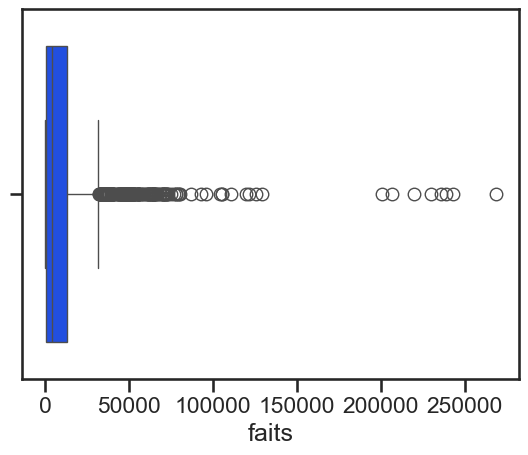

In [197]:
#Tracé de la distribution de la variable faits
sns.boxplot(x = 'faits', data = reg)
#Sans surprise, il y a également des valeurs extrêmes en région parisienne. 
reg_sorted = reg.sort_values(by = 'faits', ascending = False)
reg_sorted.head(10) 

Note : Il est parfaitement inutile d'étudier la variable catégorielle "classe" ici car pour chaque ville, toutes les classes sont affichées systématiquement

# II) Etudes statistiques  
## A) Etudes de la distribution des variables catégorielles

Le plus intéressant dans un premier temps et d'étudier quel est le type de violence la plus commise au niveau des communes, des départements et des régions. 
Normalement, les distributions devraient être identiques (si tous les rapportages ont été correctement réalisés)

### 1) Crimes et délits commis au niveau communal

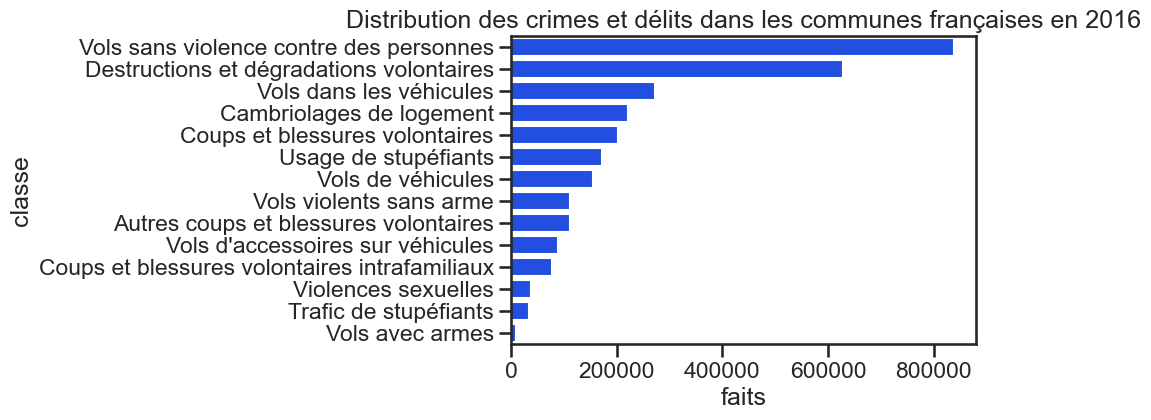

In [198]:
##DataFrame commune
#Je filtre en fonction des années, je regroupe les classes et je somme les faits de chacune des occurences de cette classe
#Ensuite je trie dans l'ordre décroissant pour un meilleur affichage de mon barplot. 
commune2016=commune.loc[commune['annee']== '2016'].groupby('classe')['faits'].sum().sort_values(ascending=False)
#commune2016gr=commune2016.groupby('classe')['faits'].sum().sort_values(ascending=False)
#commune2016gr=commune2016gr.sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (6,4)) 
sns.barplot(y=commune2016.index, x=commune2016, ax=ax)
plt.title('Distribution des crimes et délits dans les communes françaises en 2016')
plt.show()

On observe que le délit le plus commis est le vol sans violence contre des personnes. 

On cherche maintenant à faire une étude "grosse maille" de l'évolution au fil du temps des crimes et délits, afin d'en dégager des tendances. 

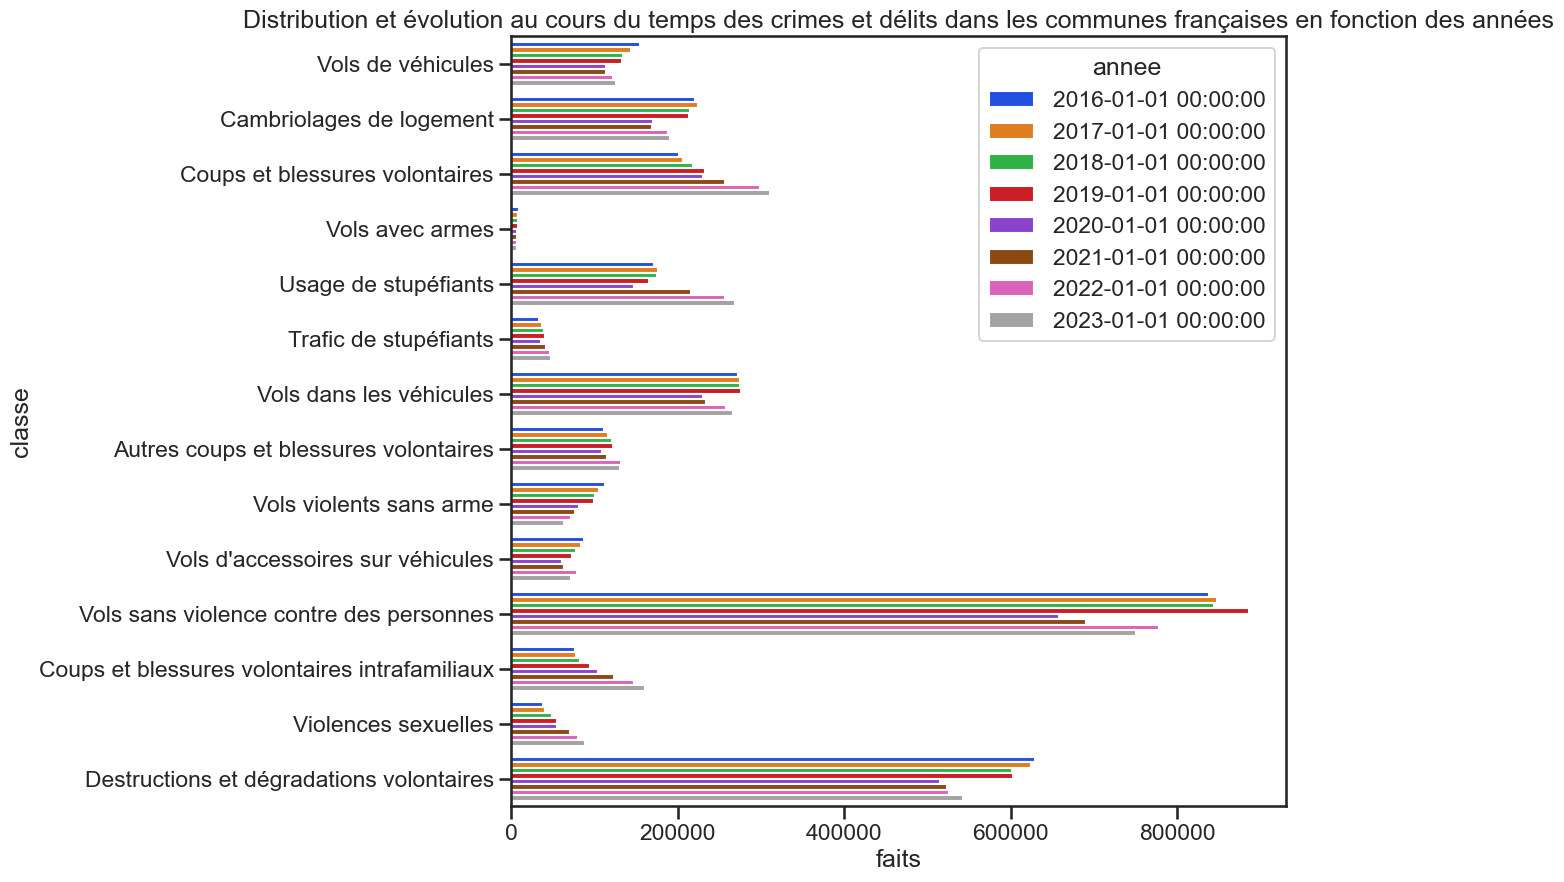

In [199]:
#Maintenant on va chercher a afficher sur le même graphique TOUTES les années, grâce à l'argument 'hue'
communeTest=commune.groupby(['classe','annee'])['faits'].sum().sort_values(ascending=False).reset_index().sort_values(by='annee')
#A noter que .reset_index().sort_values(by='annee') me permet de repasser sous forme d'un DataFrame. Ainsi, je peux librement utiliser l'argument 'hue' pour discrétiser en fonction des années.

fig, ax = plt.subplots(figsize = (10,10)) 
sns.barplot(y=communeTest.classe, x=communeTest.faits, ax=ax, hue=communeTest.annee)
plt.title('Distribution et évolution au cours du temps des crimes et délits dans les communes françaises en fonction des années')
plt.show()

On observe qu'il y a une augmentation au fil des années des coups et blessures volontaires intrafamiliaux. Cette augmentation a été beaucoup plus importante pendant et après les différents confinements. 

De même, on observe une baisse des crimes et délits lors des périodes de confinement (2019 et 2020) avant d'augmenter de nouveau. Cela est du au fait que les gens étaient confinés et par conséquent ne pouvaient enfreindre la loi. 

On observe de plus : 
- Une augmentation du trafic de stupéfiants 
- Une nette augmentation de l'usage de stupéfiants
- Une augmentation des coups et blessures volontaires
- Une très faible diminution des vols avec arme 
- Une diminution des vols violents avec arme (au profit des vols sans violence ?)
- Une triste augmentation des violences sexuelles 

On se demande quel est le top 3 des villes dans lesquels sont commis en majorité les faits ? Ce classement est-il identique selon les années ? 

In [200]:
commune.head()

,ville,annee,classe,cible,publication,faits,tauxpourmille,pop,millpop
0,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16
1,ABERGEMENT CLEMENCIAT,2016-01-01,Coups et blessures volontaires intrafamiliaux,victime,diff,0.0,0.0,767,16
2,ABERGEMENT CLEMENCIAT,2016-01-01,Autres coups et blessures volontaires,victime,ndiff,0.0,0.0,767,16
3,ABERGEMENT CLEMENCIAT,2016-01-01,Violences sexuelles,victime,diff,0.0,0.0,767,16
4,ABERGEMENT CLEMENCIAT,2016-01-01,Vols avec armes,infraction,diff,0.0,0.0,767,16


In [201]:
#Comparer l'évolution de chaque crime et délit en fonction des années
#Quel est le fait le plus commis ? 
#Compte tenu des valeurs extrêmes en région parisienne, il pourra être intéressant d'étudier séparément la région parisienne et le reste de la France. 

In [202]:
#Je me suis fait briser les vitres de ma voitures ce matin à Lille. Je me demande si c'est fréquent ? 

### 2) Crimes et délits commis au niveau départemental 
Attention bro t'as de nouvelles colonnes à étudier (statistiques exploratoires)

In [241]:
'''#Test basique de la bibliotheque Folium
geo_json_data = requests.get("https://france-geojson.gregoiredavid.fr/repo/departements.geojson").json()
m = folium.Map([47, 3], zoom_start=6.5)

folium.GeoJson(geo_json_data).add_to(m)
m'''

'#Test de la bibliotheque Folium\ngeo_json_data = requests.get("https://france-geojson.gregoiredavid.fr/repo/departements.geojson").json()\nm = folium.Map([47, 3], zoom_start=6.5)\n\nfolium.GeoJson(geo_json_data).add_to(m)\nm'

In [254]:
dep.head()

,classe,annee,departement,region,cible,millpop,faits,pop,tauxpourmille
0,Homicides,2016-01-01,AIN,AUVERGNE RHONE ALPES,victime,16,5,638425,"7,83177350511023e-03"
1,Homicides,2016-01-01,AISNE,HAUTS DE FRANCE,victime,16,10,536136,"1,86519838249996e-02"
2,Homicides,2016-01-01,ALLIER,AUVERGNE RHONE ALPES,victime,16,4,339384,"1,17860594488839e-02"
3,Homicides,2016-01-01,ALPES DE HAUTE PROVENCE,PROVENCE ALPES COTE D AZUR,victime,16,2,162565,"1,23027711992126e-02"
4,Homicides,2016-01-01,HAUTES ALPES,PROVENCE ALPES COTE D AZUR,victime,16,0,141107,"0,00000000000000e+00"


### 3) Crimes et délits commis au niveau régional
Attention il y a de nouvelles colonnes à étudier (statistiques exploratoires)